# フィルタについての復習

フィルタの設計を行う前に、フィルタの性質について復習しましょう。

簡単なフィルタの例として、2タップ（係数が2つ）の低域通過フィルタ$h[0] = 1/2, h[1] = 1/2$を考えましょう。

## 周波数特性

DTFT（離散時間フーリエ変換）を適用すると周波数特性$H(\omega)$は
\begin{equation}
    H(\omega) = \frac{1}{2} + \frac{1}{2}e^{-i\omega}
\end{equation}
となりますので、これを正規化角周波数$0 <= \omega <= \pi$の範囲でプロットしてみましょう。
$H(\omega)$は複素数ですのでプロットするためには振幅と位相に分て表します。
それぞれを振幅スペクトル、位相スペクトルと呼びます。
ここでは上式を直接計算して得られる値をグラフとしてプロットしてみます。
プロットした結果を、上式から理論的に導出できる振幅スペクトルと位相スペクトル
\begin{eqnarray*}
    A(\omega) &=& \cos\frac{\omega}{2} \\
    \theta(\omega) &=& -\frac{\omega}{2}
\end{eqnarray*}
と同じになるか確認しましょう。

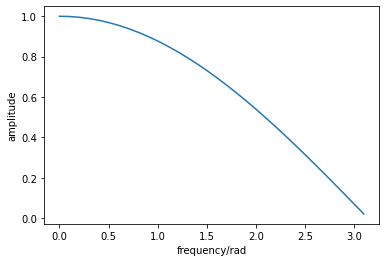

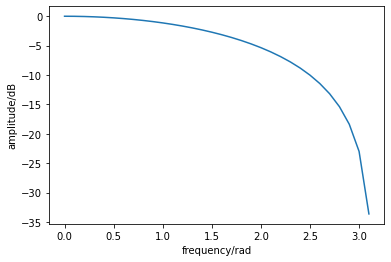

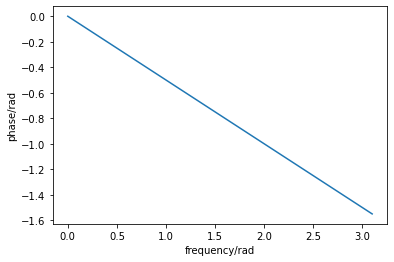

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt #matplotライブラリをpltとして読み込む
import numpy as np #numpyライブラリをnpとして読み込む
import math #mathライブラリ読み込む

omega = np.arange(0, math.pi, 0.1) # 0からpiのあいだを0.1刻みで値を生成（角周波数ωの軸の設定）

HReal = 1./2. + 1./2. * np.cos(-omega) #周波数特性の実部
HImg = 1./2. * np.sin(-omega) #周波数特性の虚部

HAmp = np.sqrt(HReal**2 + HImg**2) #Hの振幅(大きさ)計算
HPhase = np.arctan2(HImg, HReal) #Hの位相計算

plt.plot(omega, HAmp) #振幅スペクトル(x軸に角周波数ω,y軸にHの振幅をとる)　
plt.xlabel('frequency/rad') #x軸に値をプロット
plt.ylabel('amplitude') #y軸に値をプロット
plt.show() #グラフ表示

plt.plot(omega, 20*np.log10(HAmp)) #振幅スペクトルをdBで表示
plt.xlabel('frequency/rad')
plt.ylabel('amplitude/dB')
plt.show()

plt.plot(omega, HPhase) #位相スペクトル
plt.xlabel('frequency/rad')
plt.ylabel('phase/rad')
plt.show()

上述の方法はDFTが計算できた場合でしたが、タップ数が増加すると計算が面倒になります。上の例ではタップ数が2なので和は1回でしたが、DFTは理論上は無限和の計算が必要です。計算機では無限和は扱えないので、通常はタップ数を有限の$N$個に制限し、DTFS（離散時間フーリエ級数）で近似的に計算を行います。ここで$N$は$0 <= \omega <= 2\pi$の分点数を決めるので、周波数分解能に対応しています。以下の例では$N=512$として、$h[2], h[3], \dots, h[511] = 0$とみなしDTFSを計算します。DTFSを計算するためのFFTライブラリを使用します。

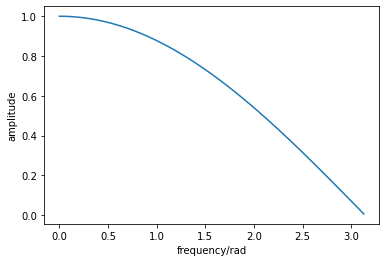

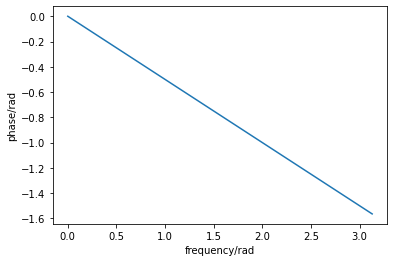

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

N = 512 #512個のデータ
h = np.zeros(N) #0をN個発生させる（h=[0,0...0]）
h[0] = 1./2.
h[1] = 1./2. #h=[1/2,1/2,0,0...0]

H = np.fft.fft(h) # FFT（高速フーリエ変換）の計算

# [0, pi]の範囲でプロット（ナイキストの定理より,Fs>=2F Fs=2pi,F=pi）
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N #((0~256)*2pi/N)

plt.plot(freq, np.absolute(H[0:int(N/2)]))#absolute:絶対値計算関数
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.show()

plt.plot(freq, np.angle(H[0:int(N/2)])) #angle:位相計算関数
plt.xlabel('frequency/rad')
plt.ylabel('phase/rad')
plt.show()




## 信号のスペクトル
与えられた信号に対して同様にDTFSを適用し、そのスペクトルを求めてみましょう。

以下のような2つの正弦波を組み合わせた信号を考えてみます。
\begin{equation}
    x[n] = \sin\left(\frac{\pi}{4}n\right) + \cos\left(\frac{3\pi}{4}n\right)
\end{equation}
音声信号を扱うときには位相を問題にしません。人間の耳は音の大きさと周波数の違いを聞き分けられますが、
位相の違いまでは聞き分けられません。そこで今回は振幅スペクトルのみを$[0, \pi]$の範囲で表示します。

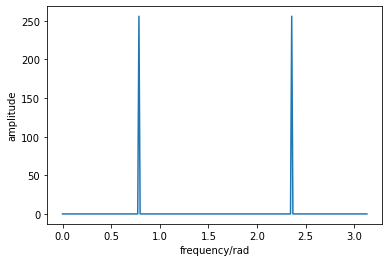

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

N = 512 # 標本点数
n = np.arange(0, N) #0~Nで列挙

x = np.sin(math.pi * n / 4.0) + np.cos(3 * math.pi * n / 4.0) #x[n]=sin(pi*n/4)+cos(3pi*n/4)

X = np.fft.fft(x) # FFT実行

freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(X[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.show()


上図で1つ目のピークは$\omega = \pi/4 \simeq 0.79$に、2つ目のピークは$\omega = 3\pi/4 \simeq 2.36$に対応していることがわかります。

## たたみ込み
これまで2タップのフィルタと、与えられた信号のそれぞれの周波数領域表現をみてきました。
それでは次に与えられた信号を2タップのフィルタに入力した時の出力を計算してみましょう。
このとき利用されるのが「たたみ込み」と呼ばれる演算です。
タップ数が$N$の場合、以下のように表現されます。
\begin{equation}
    y[n] = \sum_{k = 0}^{N - 1} h[k] x[n - k]
\end{equation}

Pythonでたたみ込み演算を実現するためには、直接上記の式を計算する方法もありますが、
SciPyと呼ばれるパッケージを利用すると、たたみ込みを行う関数がありますので、
こちらを利用しましょう。

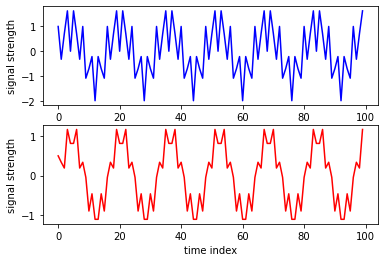

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal #scipyパッケージからsignalライブラリを読み込む
import math

N = 512 # 標本点数
n = np.arange(0, N) #0~Nで列挙
x = np.sin(math.pi * n / 8.0) + np.cos(3 * math.pi * n / 4.0) #x[n]=sin(pi*n/8)+cos(3pi*n/4)

numTap = 2 # フィルタのタップ数
h = np.zeros(numTap) #h=[1/2,1/2]
h[0] = 1./2.
h[1] = 1./2.

# たたみ込み実行
y = signal.convolve(h, x, mode='full')

# 最初の100点のみプロットする
plt.subplot(2, 1, 1)
plt.plot(n[0:100], x[0:100], 'b')
plt.xlabel('time index')
plt.ylabel('signal strength')

plt.subplot(2, 1, 2)
plt.plot(n[0:100], y[0:100], 'r' )
plt.xlabel('time index')
plt.ylabel('signal strength')
plt.show()

上の例では入力信号$x[n]$と出力信号$y[n]$を時間領域で観測しましたが、次はそれぞれの信号の振幅スペクトルを見てみましょう。

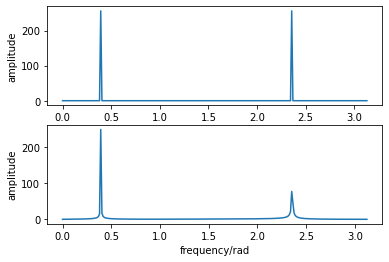

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

N = 512 # 標本点数
n = np.arange(0, N)
x = np.sin(math.pi * n / 8.0) + np.cos(3 * math.pi * n / 4.0)

numTap = 2 # フィルタのタップ数
h = np.zeros(numTap) 
h[0] = 1./2.
h[1] = 1./2.

# たたみ込み実行
y = signal.convolve(h, x, mode='full')

# x, yそれぞれのFFT
X = np.fft.fft(x)
Y = np.fft.fft(y)

# [0, pi]でスペクトルを表示
plt.subplot(2, 1, 1)
freq = np.arange(0, int(N/2)) * 2 * math.pi / N
plt.plot(freq, np.absolute(X[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')

plt.subplot(2, 1, 2)
freq = np.arange(int(Y.size/2)) * 2 * math.pi / Y.size
plt.plot(freq, np.absolute(Y[0:int(Y.size/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.show()



上図の下段は出力$y[n]$の振幅スペクトルを表しています。左側のスペクトルピークの大きさは上段のそれとはあまり変わりませんが、右側のスペクトルピークが上段のそれよりもかなり小くなっていることがわかります。これは2タップフィルタの周波数特性から説明が可能です。つまり、$\omega = 3\pi/4 \simeq 2.36$でフィルタの周波数特性が$0.3\sim0.4$ですので、振幅が小さくなることを意味します。一方$\omega = \pi/4 \simeq 0.79$では周波数特性が$0.9$程度ですので、こちらの振幅はほとんど変化がありません。このように周波数を選択的に通過させたり、抑制したりする効果があるので「フィルタ」と呼ばれます。

演習

2タップのフィルタ係数が$h[0] = 1/2, h[1] = -1/2$のとき、周波数特性を求めなさい。

また、信号
\begin{equation}
    x[n] = \sin\left(\frac{\pi}{4}n\right) + \cos\left(\frac{3\pi}{4}n\right)
\end{equation}
を入力したときの出力信号を図示するとともに、それらの振幅スペクトルがどのように変化するかも図示しなさい。

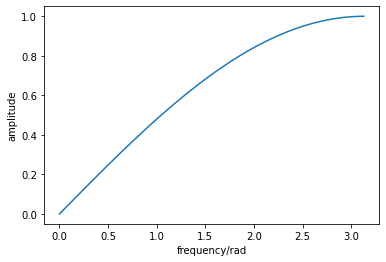

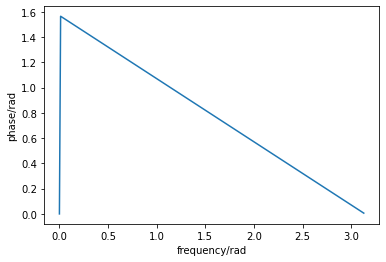

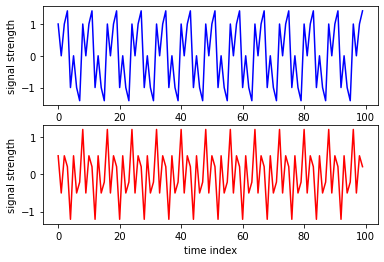

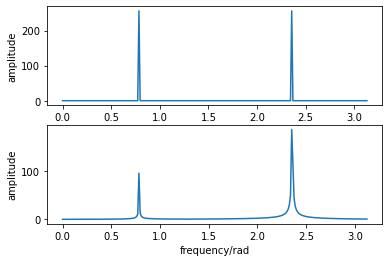

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import signal

#1.周波数特性
N = 512 #512個のデータ
h = np.zeros(N) #0をN個発生させる（h=[0,0...0]）
h[0] = 1./2.
h[1] = -1./2. #h=[1/2,-1/2,0,0...0]

H = np.fft.fft(h) # FFT（高速フーリエ変換）の計算

# [0, pi]の範囲でプロット（ナイキストの定理より,Fs>=2F Fs=2pi,F=pi）
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N #((0~256)*2pi/N)

plt.plot(freq, np.absolute(H[0:int(N/2)]))#absolute:絶対値計算関数
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.show()

plt.plot(freq, np.angle(H[0:int(N/2)])) #angle:位相計算関数
plt.xlabel('frequency/rad')
plt.ylabel('phase/rad')
plt.show()

#2.出力信号
n = np.arange(0, N) #0~Nで列挙
x = np.sin(math.pi * n / 4.0) + np.cos(3 * math.pi * n / 4.0) #x[n]=sin(pi*n/4)+cos(3pi*n/4)

numTap = 2 # フィルタのタップ数
h = np.zeros(numTap) #h=[1/2,-1/2]
h[0] = 1./2.
h[1] = -1./2.

# たたみ込み実行
y = signal.convolve(h, x, mode='full')

# 最初の100点のみプロットする
plt.subplot(2, 1, 1)
plt.plot(n[0:100], x[0:100], 'b')
plt.xlabel('time index')
plt.ylabel('signal strength')

plt.subplot(2, 1, 2)
plt.plot(n[0:100], y[0:100], 'r' )
plt.xlabel('time index')
plt.ylabel('signal strength')
plt.show()


#3.出力信号の振幅スペクトル

# x, yそれぞれのFFT
X = np.fft.fft(x)
Y = np.fft.fft(y)

# [0, pi]でスペクトルを表示
plt.subplot(2, 1, 1)
freq = np.arange(0, int(N/2)) * 2 * math.pi / N
plt.plot(freq, np.absolute(X[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')

plt.subplot(2, 1, 2)
freq = np.arange(int(Y.size/2)) * 2 * math.pi / Y.size
plt.plot(freq, np.absolute(Y[0:int(Y.size/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.show()






# 窓関数法によるフィルタ設計

窓関数法では、理想的な周波数特性から得られるインパルス応答（タップ係数）$h[n]$を有限項で打ち切ることによりフィルタを実現します。理想的な周波数特性に逆DTFTを適用しインパルス応答を求めると、インパルス応答が無限に続き実現ができません。そこでインパルス応答に「窓関数」をかけることによりインパルス応答を有限項で打ち切ります。このことから窓関数法と呼ばれます。

まず最初に周波数変換を用いて、簡易的にフィルタ設計を行う方法を示し、その結果からフィルタ設計の基本的な考え方を見てみましょう。

また、SciPyモジュールでは窓関数法によるフィルタ設計を行う関数firwinがありますので、そちらを使用した場合の結果とも比較してみましょう。この関数では窓関数の種類を指定できますので、窓関数を変えた時に得られるフィルタの特性がどのように変わるかも確認しましょう。

## 周波数変換によるフィルタ設計の例

ここではすでに出た低域通過フィルタの設計を行ってみます。手続きは以下の通りです。
1. FFTを計算するときの分点数を決めます。
2. カットオフ周波数を決め、理想特性を描きます。このとき周期が$2\pi$であることを忘れないでください。
3. IFFTを適用し、インパルス応答を求めます。必要な応答長のみ係数を採用し、それ以外を$0$にします。
4. 得られたフィルタの周波数特性を確認します。


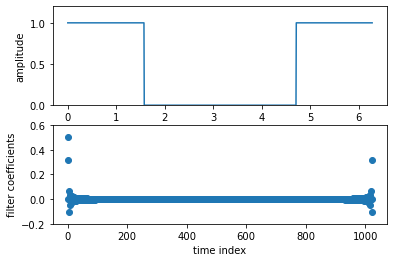

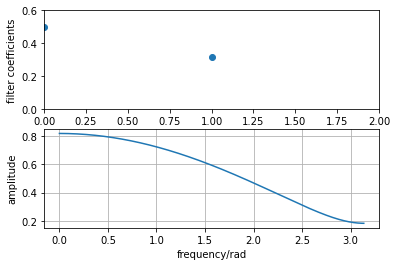

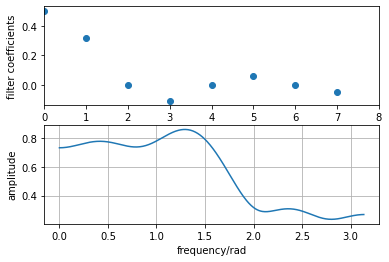

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

N = 1024 #分点数
cutoff = math.pi/2. #カットオフ周波数（-3dB~2^-1/2）の定義

# 理想特性を作成する。半分作成し、折り返して接続する。
H = np.zeros(int(N/2)+1)
n = int(cutoff / (2.0*math.pi) * N) # カットオフ周波数に対応するインデックス
H[0:(n+1)] = 1 # 低域通過の理想特性
HAmp = np.concatenate((H, H[-2:0:-1]))

# IFFT(逆高速フーリエ変換)によりインパルス応答を求める
h = np.fft.ifft(HAmp)
h = h.real #虚数部はほぼ0になる。計算誤差で極めて小さい値が保持されているので除去。

plt.subplot(2, 1, 1)
freq = np.arange(N) * 2.0 * math.pi / N
plt.plot(freq, HAmp)
plt.ylim((0, 1.2))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')

plt.subplot(2, 1, 2)
plt.plot(h, 'o')
plt.xlabel('time index')
plt.ylim(-0.2, 0.6)
plt.ylabel('filter coefficients')
plt.show()


# 最初の2点で打ち切った場合の周波数特性を求める
h1 = np.zeros(N)
h1[0:2] = h[0:2]
H1 = np.fft.fft(h1)

plt.subplot(2, 1, 1)
plt.plot(h1[0:2], 'o')
plt.xlim(0, 2)
plt.ylim(0, 0.6)
plt.xlabel('time index')
plt.ylabel('filter coefficients')

plt.subplot(2, 1, 2)
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()


# 最初の8点で打ち切った場合の周波数特性を求める
h1 = np.zeros(N)
h1[0:8] = h[0:8]
H1 = np.fft.fft(h1)

plt.subplot(2, 1, 1)
plt.plot(h1[0:8], 'o')
plt.xlim(0, 8)
plt.xlabel('time index')
plt.ylabel('filter coefficients')

plt.subplot(2, 1, 2)
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

フィルタ係数を2点で打ち切った場合は、最初に与えた理想特性に比べてかなりなだらかな周波数特性になっています。このため指定したカットオフ周波数前後の特性が悪い事がわかります。また、$h[0] = 0.5$、$h[1] = 0.3$ですので、フィルタの復習の項で説明した低域通過フィルタ$h[0] = 1/2, h[1] = 1/2$の係数と近い値であることもわかります。

演習

フィルタのタップ数を16, 32と増やすと周波数特性はどのように変わるでしょうか。周波数特性を描き気が付いたことをまとめましょう。

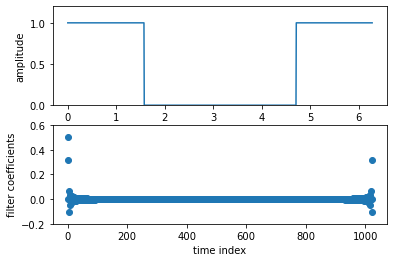

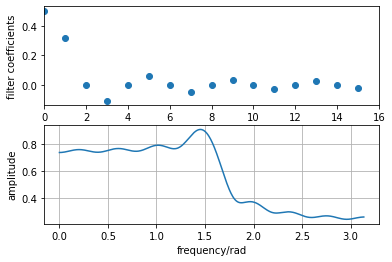

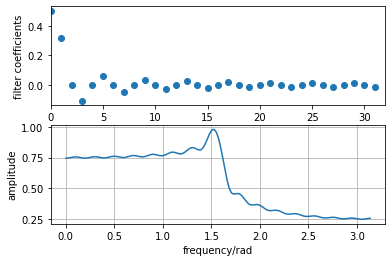

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

N = 1024 #分点数
cutoff = math.pi/2. #カットオフ周波数（-3dB~2^-1/2）の定義

# 理想特性を作成する。半分作成し、折り返して接続する。
H = np.zeros(int(N/2)+1)
n = int(cutoff / (2.0*math.pi) * N) # カットオフ周波数に対応するインデックス
H[0:(n+1)] = 1 # 低域通過の理想特性
HAmp = np.concatenate((H, H[-2:0:-1]))

# IFFT(逆高速フーリエ変換)によりインパルス応答を求める
h = np.fft.ifft(HAmp)
h = h.real #虚数部はほぼ0になる。計算誤差で極めて小さい値が保持されているので除去。

plt.subplot(2, 1, 1)
freq = np.arange(N) * 2.0 * math.pi / N
plt.plot(freq, HAmp)
plt.ylim((0, 1.2))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')

plt.subplot(2, 1, 2)
plt.plot(h, 'o')
plt.xlabel('time index')
plt.ylim(-0.2, 0.6)
plt.ylabel('filter coefficients')
plt.show()


# 最初の16点で打ち切った場合の周波数特性を求める
h1 = np.zeros(N)
h1[0:16] = h[0:16]
H1 = np.fft.fft(h1)

plt.subplot(2, 1, 1)
plt.plot(h1[0:16], 'o')
plt.xlim(0, 16)
plt.xlabel('time index')
plt.ylabel('filter coefficients')

plt.subplot(2, 1, 2)
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()


# 最初の32点で打ち切った場合の周波数特性を求める
h1 = np.zeros(N)
h1[0:32] = h[0:32]
H1 = np.fft.fft(h1)

plt.subplot(2, 1, 1)
plt.plot(h1[0:32], 'o')
plt.xlim(0, 32)
plt.xlabel('time index')
plt.ylabel('filter coefficients')

plt.subplot(2, 1, 2)
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

フィルタのタップ数を16にすると、振幅の小さなブレが目立ちやすくなり、特に周波数が1.5の近傍で振幅が大きく変化したことから、周波数特性を細かく解析できた。一方で、タップ数を32にするとタップ数が16のときよりも振幅が大きく変化し、周波数特性をさらに細かく解析できた。

## 窓関数法によるフィルタ設計

Scipyにはfirwin関数があり、これをもちいてフィルタ設計を行うことができます。ここでは低域通貨フィルタの設計例を示します。firwin関数を用いるときには引数の設定に注意が必要です。通常ディジタル信号の教科書ではサンプリング周波数を正規化周波数$1$に対応させますが、firwinではナイキスト周波数を$1$としたときにカットオフ周波数がいくらになるかを換算して、引数に与えます。例えばサンプリング周波数$F_s = 8000Hz$のとき、カットオフ周波数を$1000Hz$と設定するためには、ナイキスト周波数$F_s/2 = 4000Hz$に対する比率として$1000Hz/4000Hz = 0.25$を用います。

上の例ではカットオフ角周波数を$\pi/2$radと設定していたので、同様な低域通過フィルタを設計するためにはfirwinに与えるカットオフ周波数を$1/2$とします。タップ数を$2$としたときと$8$としたときの設計例を以下に示します。


[0.5 0.5]


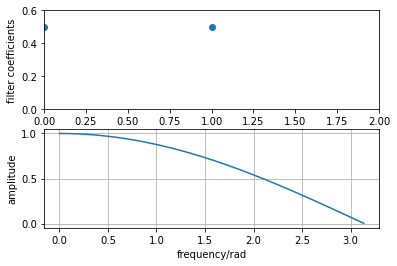

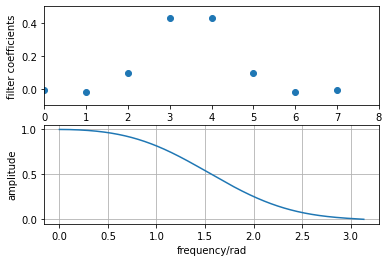

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

cutoff = 0.5 #カットオフ周波数

# タップ数2で設計したときの周波数特性を求める
numTap = 2
h = signal.firwin(numTap, cutoff) #firwin関数で計算
print(h)

# FFTを用いて周波数特性を求める
N = 1024
h1 = np.zeros(N)
h1[0:2] = h
H1 = np.fft.fft(h1)

plt.subplot(2, 1, 1)
plt.plot(h1[0:numTap], 'o')
plt.xlim(0, numTap)
plt.ylim(0, 0.6)
plt.xlabel('time index')
plt.ylabel('filter coefficients')

plt.subplot(2, 1, 2)
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()


# タップ数8で設計したときの周波数特性を求める
numTap = 8
h = signal.firwin(numTap, cutoff)


# FFTを用いて周波数特性を求める
N = 1024
h1 = np.zeros(N)
h1[0:numTap] = h
H1 = np.fft.fft(h1)

plt.subplot(2, 1, 1)
plt.plot(h1[0:numTap], 'o')
plt.xlim(0, numTap)
plt.ylim(-0.1, 0.5)
plt.xlabel('time index')
plt.ylabel('filter coefficients')

plt.subplot(2, 1, 2)
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

演習
上の例でタップ数を$16$、$32$と増やしたときのフィルタ係数とその周波数特性を求めなさい。

[-0.00240945 -0.00416218  0.00953649  0.01997093 -0.03795418 -0.06957283
  0.13736084  0.44723039  0.44723039  0.13736084 -0.06957283 -0.03795418
  0.01997093  0.00953649 -0.00416218 -0.00240945]


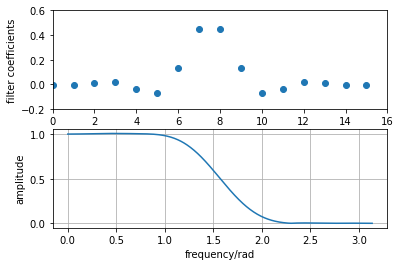

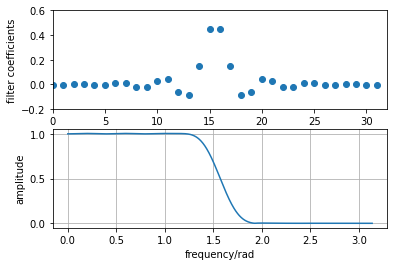

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

cutoff = 0.5 #カットオフ周波数

# タップ数16で設計したときの周波数特性を求める
numTap = 16
h = signal.firwin(numTap, cutoff) #firwin関数で計算
print(h)

# FFTを用いて周波数特性を求める
N = 1024
h1 = np.zeros(N)
h1[0:numTap] = h
H1 = np.fft.fft(h1)

plt.subplot(2, 1, 1)
plt.plot(h1[0:numTap], 'o')
plt.xlim(0, numTap)
plt.ylim(-0.2, 0.6)
plt.xlabel('time index')
plt.ylabel('filter coefficients')

plt.subplot(2, 1, 2)
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

# タップ数32で設計したときの周波数特性を求める
numTap = 32
h = signal.firwin(numTap, cutoff)


# FFTを用いて周波数特性を求める
N = 1024
h1 = np.zeros(N)
h1[0:numTap] = h
H1 = np.fft.fft(h1)

plt.subplot(2, 1, 1)
plt.plot(h1[0:numTap], 'o')
plt.xlim(0, numTap)
plt.ylim(-0.2, 0.6)
plt.xlabel('time index')
plt.ylabel('filter coefficients')

plt.subplot(2, 1, 2)
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

タップ数を2、8、16、32と増加させたときに周波数特性がどのように変化したか、気づいたことを書きなさい。

タップ数を増加させるにつれて、一定の角周波数の閾値で振幅の立下りが急になり、周波数特性が連続的から離散的に向かうように変化した。

演習

タップ数32、カットオフ角周波数$\pi/2$で設計したフィルタを用い、「たたみ込み」の節で用いた入力信号をフィルタ処理した出力を計算し、グラフとして表示しましょう。出力結果は以前の結果と比較して何が変わったでしょうか。

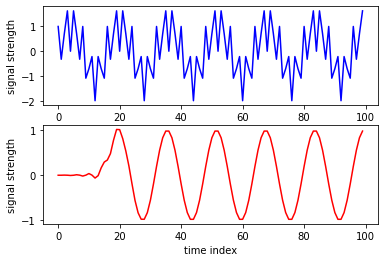

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal #scipyパッケージからsignalライブラリを読み込む
import math

N = 512 # 標本点数
n = np.arange(0, N) #0~Nで列挙
x = np.sin(math.pi * n / 8.0) + np.cos(3 * math.pi * n / 4.0) #x[n]=sin(pi*n/8)+cos(3pi*n/4)

numTap = 32 # フィルタのタップ数
cutoff=0.5
h = signal.firwin(numTap, cutoff)

# たたみ込み実行
y = signal.convolve(h, x, mode='full')

# 最初の100点のみプロットする
plt.subplot(2, 1, 1)
plt.plot(n[0:100], x[0:100], 'b')
plt.xlabel('time index')
plt.ylabel('signal strength')

plt.subplot(2, 1, 2)
plt.plot(n[0:100], y[0:100], 'r' )
plt.xlabel('time index')
plt.ylabel('signal strength')
plt.show()

以前の結果と比較すると、入力した信号はタップ数（32点）だけ遅延した後にフィルタが掛かり、その後はフィルタによって雑音が除去され、滑らかな信号として出力された。

演習

上の出力信号をスペクトルとして表示しましょう。以前の結果と比較して何が変わったでしょうか。

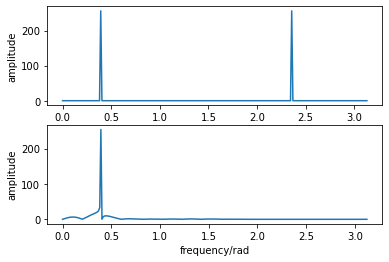

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

N = 512 # 標本点数
n = np.arange(0, N)
x = np.sin(math.pi * n / 8.0) + np.cos(3 * math.pi * n / 4.0)

numTap = 32 # フィルタのタップ数
cutoff=0.5
h = signal.firwin(numTap, cutoff)

# たたみ込み実行
y = signal.convolve(h, x, mode='full')

# x, yそれぞれのFFT
X = np.fft.fft(x)
Y = np.fft.fft(y)

# [0, pi]でスペクトルを表示
plt.subplot(2, 1, 1)
freq = np.arange(0, int(N/2)) * 2 * math.pi / N
plt.plot(freq, np.absolute(X[0:int(N/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')

plt.subplot(2, 1, 2)
freq = np.arange(int(Y.size/2)) * 2 * math.pi / Y.size
plt.plot(freq, np.absolute(Y[0:int(Y.size/2)]))
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.show()

以前の結果と比較すると、入力信号では振幅スペクトルが2か所あったが、フィルタを通した後の出力信号では振幅スペクトルが1か所になる周波数特性が得られ、フィルタによる効果がみられた。

firwin関数では窓関数法で使用する窓の種類を指定できます。ここではタップ数を$8$、カットオフ各周波数を$\pi/2$に固定した時に、窓関数の種類によって周波数特性がどのように変化するかを確認してみます。



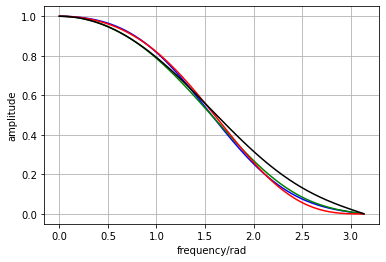

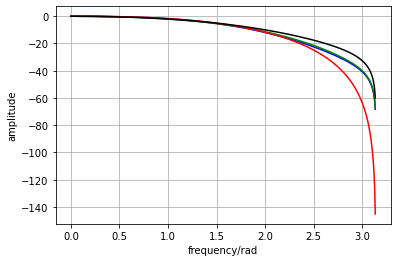

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

cutoff = 0.5 # カットオフ周波数
numTap = 8 # タップ数

h_hamming = signal.firwin(numTap, cutoff) # デフォルトはHamming（ハミング窓）
h_hann = signal.firwin(numTap, cutoff, window='hann') # Hanning（ハニング窓）
h_bartlett = signal.firwin(numTap, cutoff, window='bartlett') # Bartlett（バートレット窓）
h_parzen = signal.firwin(numTap, cutoff, window='parzen') # Parzen（パルザン窓）


# FFTを用いて周波数特性を求める
N = 1024
h1 = np.zeros(N)
h1[0:numTap] = h_hamming
H1 = np.fft.fft(h1)

h2 = np.zeros(N)
h2[0:numTap] = h_hann
H2 = np.fft.fft(h2)

h3 = np.zeros(N)
h3[0:numTap] = h_bartlett
H3 = np.fft.fft(h3)

h4 = np.zeros(N)
h4[0:numTap] = h_parzen
H4 = np.fft.fft(h4)

freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]), 'b', \
         freq, np.absolute(H2[0:int(N/2)]), 'g', \
         freq, np.absolute(H3[0:int(N/2)]), 'r', \
         freq, np.absolute(H4[0:int(N/2)]), 'k')
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

plt.plot(freq, 20 * np.log10( np.absolute(H1[0:int(N/2)]) ), 'b', \
         freq, 20 * np.log10( np.absolute(H2[0:int(N/2)]) ), 'g', \
         freq, 20 * np.log10( np.absolute(H3[0:int(N/2)]) ), 'r', \
         freq, 20 * np.log10( np.absolute(H4[0:int(N/2)]) ), 'k' )
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

演習

上の例で、タップ数を32にしたとき周波数特性が窓関数によってどのように変わるかを確かめなさい。

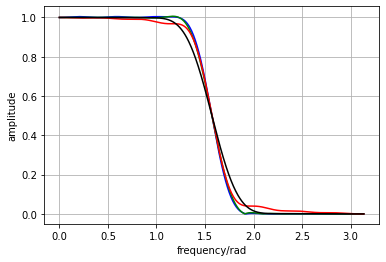

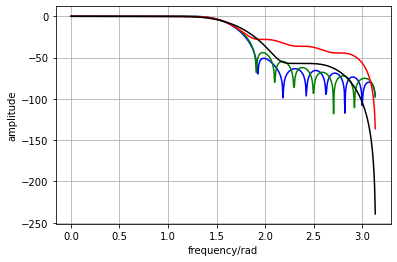

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

cutoff = 0.5 # カットオフ周波数
numTap = 32 # タップ数

h_hamming = signal.firwin(numTap, cutoff) # デフォルトはHamming（ハミング窓）
h_hann = signal.firwin(numTap, cutoff, window='hann') # Hanning（ハニング窓）
h_bartlett = signal.firwin(numTap, cutoff, window='bartlett') # Bartlett（バートレット窓）
h_parzen = signal.firwin(numTap, cutoff, window='parzen') # Parzen（パルザン窓）


# FFTを用いて周波数特性を求める
N = 1024
h1 = np.zeros(N)
h1[0:numTap] = h_hamming
H1 = np.fft.fft(h1)

h2 = np.zeros(N)
h2[0:numTap] = h_hann
H2 = np.fft.fft(h2)

h3 = np.zeros(N)
h3[0:numTap] = h_bartlett
H3 = np.fft.fft(h3)

h4 = np.zeros(N)
h4[0:numTap] = h_parzen
H4 = np.fft.fft(h4)

#青はハミング窓
#緑はハニング窓
#赤はバートレット窓
#黒はバルサン窓
freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]), 'b', \
         freq, np.absolute(H2[0:int(N/2)]), 'g', \
         freq, np.absolute(H3[0:int(N/2)]), 'r', \
         freq, np.absolute(H4[0:int(N/2)]), 'k')
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

plt.plot(freq, 20 * np.log10( np.absolute(H1[0:int(N/2)]) ), 'b', \
         freq, 20 * np.log10( np.absolute(H2[0:int(N/2)]) ), 'g', \
         freq, 20 * np.log10( np.absolute(H3[0:int(N/2)]) ), 'r', \
         freq, 20 * np.log10( np.absolute(H4[0:int(N/2)]) ), 'k' )
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

4つの窓関数の周波数特性について、絶対値で振幅を比較すると変化はさほどみられないが、常用対数によりdBに変換して比較すると、周波数が増加するにつれて窓関数それぞれに固有の変化が生じた。特にハミング窓とハニング窓では振動する変化がみられた。

## 他の特性をもつフィルタ設計

firwin関数では低域通過フィルタだけでなく、高域通過フィルタ、帯域通過フィルタ、帯域阻止フィルタといったフィルタも設計できます。firwin関数のマニュアルを参考にしこれらのフィルタを設計した例を示します。


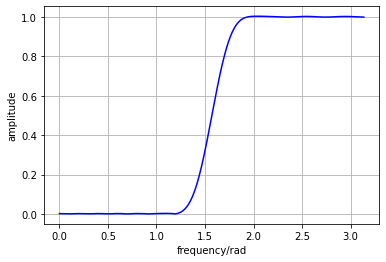

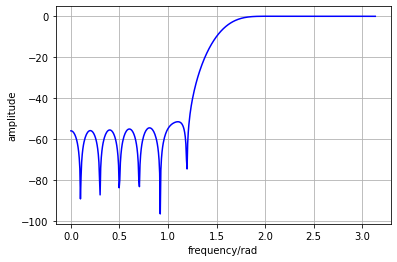

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

cutoff = 0.5 # カットオフ周波数
numTap = 31 # タップ数、奇数

# 高域通過フィルタ(HPF)
h = signal.firwin(numTap, cutoff, pass_zero=False) 

# FFTを用いて周波数特性を求める
N = 1024
h1 = np.zeros(N)
h1[0:numTap] = h
H1 = np.fft.fft(h1)

freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]), 'b')
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

plt.plot(freq, 20 * np.log10( np.absolute(H1[0:int(N/2)]) ), 'b')
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

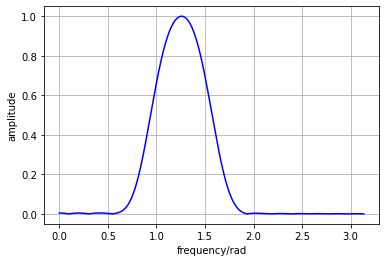

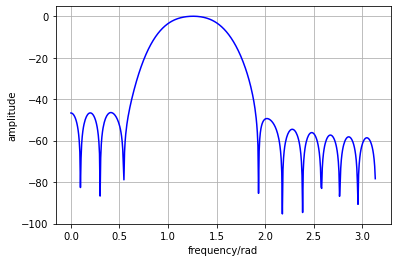

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math

cutoff = [0.3, 0.5] # カットオフ周波数
numTap = 32 # タップ数、偶数

# 帯域通過フィルタ(BPF)
h = signal.firwin(numTap, cutoff, pass_zero=False) 

# FFTを用いて周波数特性を求める
N = 1024
h1 = np.zeros(N)
h1[0:numTap] = h
H1 = np.fft.fft(h1)

freq = np.arange(0, int(N/2)) * 2.0 * math.pi / N
plt.plot(freq, np.absolute(H1[0:int(N/2)]), 'b')
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

plt.plot(freq, 20 * np.log10( np.absolute(H1[0:int(N/2)]) ), 'b')
plt.xlabel('frequency/rad')
plt.ylabel('amplitude')
plt.grid()
plt.show()

# 音源の作成

フィルタの効果を試すための音源を準備します。正弦波を組み合わせた和音が、指定された時間一定の振幅で続く音を生成しその結果をwaveファイルに保存します。

ここではサンプリング周波数を8000Hzとし、C4(261.63Hz)、E4(329.63Hz)、G4(392Hz)を組み合わせて和音を作成します。

In [17]:
import math
import numpy as np
from scipy.io import wavfile 

"""
信号を発生する長さが短いので全データを配列に作成し書き込むことにする。
"""

samplingRate = 8000 # サンプリング周波数Fs Hz
samplingPeriod = 1.0/samplingRate # サンプリング周期Ts sec
duration = 5 # 信号発生長 sec
wavFileName = 'source.wav'

# 正弦波の周波数
f_c4 = 261.63
f_e4 = 329.63
f_g4 = 392

# wave用データ作成
timeIndex = np.arange(samplingRate * duration)
wdata = np.sin(2.0 * math.pi * f_c4 * samplingPeriod * timeIndex) \
    + np.sin(2.0 * math.pi * f_e4 * samplingPeriod * timeIndex) \
    + np.sin(2.0 * math.pi * f_g4 * samplingPeriod * timeIndex)
wdata = wdata / np.amax(wdata)

# Windowsの場合はfloat型のwaveをサポートしてないので16bit intへ変換する。
wdata = np.int16(wdata*32767.0)

# waveファイルに書き込み
wavfile.write(wavFileName, samplingRate, wdata)



演習

C4, E4, G4をそれぞれ単独で生成したとき、それぞれの音を個別のwaveファイルに保存し、
和音と聞き比べをしてみましょう。


それぞれの音を単独で生成してwaveファイルに保存し、気づいたことをまとめましょう。

フィルタにより和音のwaveファイルから構成音の周波数を指定して取り出すと、音が特定できた。同じ音量で比較すると、低周波の音源は音圧が小さく、高周波の音源は音圧が大きいことが分かった。

## フィルタ利用の例
和音から単一の正弦波のみを取り出してみましょう。上で作成した音源からC4に対応する正弦波を低域通過フィルタで抽出してみます。カットオフ周波数を295.63Hzとすると、サンプリング周波数8000Hzでは正規化周波数295.63/8000となります。ただしfirwin関数で設計する場合は前述の注意にもあったとおりナイキスト周波数に対する比率で指定しますので、295.63/4000をカットオフ周波数とします。C4, E4, G4が接近していますので急峻な特性を持たせるためタップ長をこれまでの例より長くしています。

int16


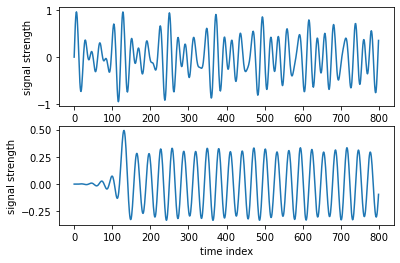

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math
from scipy.io import wavfile 

cutoff = 295.63/4000
numTap = 256
h = signal.firwin(numTap, cutoff)

# waveファイルからの読み込み
sourceFileName = 'source.wav'
samplingRate, wdata = wavfile.read(sourceFileName)
print(wdata.dtype)

# 一旦floatへ戻す
wdata = np.float64(wdata)/32767.0

# たたみ込み実行
y = signal.convolve(h, wdata, mode='full')

# yをint16へ変換
# Windowsの場合はfloat型のwaveをサポートしてないので16bit intへ変換する。
y_int16 = np.int16(y*32767.0)
# waveファイルへ書き込む
outputFileName = 'output.wav'
wavfile.write(outputFileName, samplingRate, y_int16)

plt.subplot(2, 1, 1)
plt.plot(np.arange(800), wdata[0:800])
plt.xlabel('time index')
plt.ylabel('signal strength')

plt.subplot(2, 1, 2)
plt.plot(np.arange(800), y[0:800])
plt.xlabel('time index')
plt.ylabel('signal strength')
plt.show()

フィルタ係数の数を変えて確認してください。128、512、等変えたとき、出力はどのように変化しますか。

フィルタ係数を大きくすると、出力信号は入力信号に比べて信号の遅延が大きくなるが、その分出力信号の波形はより周期信号に近づくことがわかる。

演習

G4を取り出すための高域通過フィルタを設計し、その出力信号を示すとともにwaveファイルとして保存してください。

int16


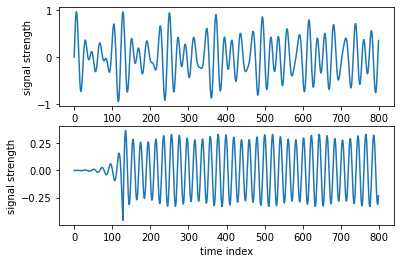

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math
from scipy.io import wavfile 

cutoff = 360.815/4000
numTap = 257
h = signal.firwin(numTap, cutoff, pass_zero=False)

# waveファイルからの読み込み
sourceFileName = 'source.wav'
samplingRate, wdata = wavfile.read(sourceFileName)
print(wdata.dtype)

# 一旦floatへ戻す
wdata = np.float64(wdata)/32767.0

# たたみ込み実行
y = signal.convolve(h, wdata, mode='full')

# yをint16へ変換
# Windowsの場合はfloat型のwaveをサポートしてないので16bit intへ変換する。
y_int16 = np.int16(y*32767.0)
# waveファイルへ書き込む
outputFileName = 'output_G4.wav'
wavfile.write(outputFileName, samplingRate, y_int16)

plt.subplot(2, 1, 1)
plt.plot(np.arange(800), wdata[0:800])
plt.xlabel('time index')
plt.ylabel('signal strength')

plt.subplot(2, 1, 2)
plt.plot(np.arange(800), y[0:800])
plt.xlabel('time index')
plt.ylabel('signal strength')
plt.show()

HPFにより、G4に相当する周波数成分の信号のみが取り出されて出力された。

演習

E4を取り出すための帯域通過フィルタを設計し、その出力信号を示すとともにwaveファイルとして保存してください。

int16


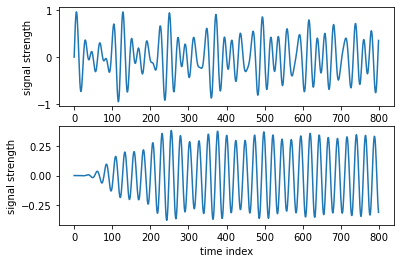

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import math
from scipy.io import wavfile 

cutoff = [295.63/4000,360.815/4000]
numTap = 256
h = signal.firwin(numTap, cutoff, pass_zero=False)

# waveファイルからの読み込み
sourceFileName = 'source.wav'
samplingRate, wdata = wavfile.read(sourceFileName)
print(wdata.dtype)

# 一旦floatへ戻す
wdata = np.float64(wdata)/32767.0

# たたみ込み実行
y = signal.convolve(h, wdata, mode='full')

# yをint16へ変換
# Windowsの場合はfloat型のwaveをサポートしてないので16bit intへ変換する。
y_int16 = np.int16(y*32767.0)
# waveファイルへ書き込む
outputFileName = 'output_E4.wav'
wavfile.write(outputFileName, samplingRate, y_int16)

plt.subplot(2, 1, 1)
plt.plot(np.arange(800), wdata[0:800])
plt.xlabel('time index')
plt.ylabel('signal strength')

plt.subplot(2, 1, 2)
plt.plot(np.arange(800), y[0:800])
plt.xlabel('time index')
plt.ylabel('signal strength')
plt.show()

BPFにより、C4とG4の間に相当する周波数成分の信号であるE4が取り出されて出力された。